In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time

if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.size": 22, "font.family": "serif", "font.serif": ["computer modern roman"]})
plt.rcParams.update({"font.size": 22})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

times = r"$\times$"
pwr_neg = r"$^{-1}$"


The path is: /home/ucecabj/Desktop/MFI_git


### Figure1A: On the fly Error in 1D.

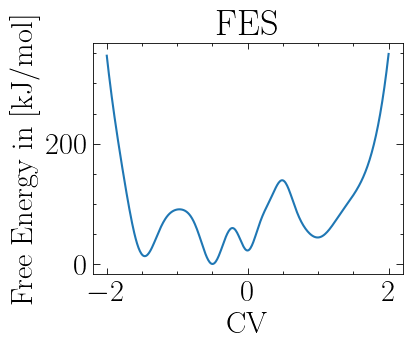

In [2]:
#Define grid and analytical function
x=np.linspace(-2,2,401)
y=1*x**8-50*np.exp(-(x-1)**2/0.1)-93*np.exp(-(x+0.5)**2/0.05)-103*np.exp(-(x+1.5)**2/0.07)-70*np.exp(-(x)**2/0.03)+50*np.exp(-(x-0.5)**2/0.03)
y = y - np.min(y)

#Plot function
plt.figure(figsize=(4,3)); plt.plot(x,y); plt.xlabel("CV"); plt.ylabel("Free Energy in [kJ/mol]"); plt.title("FES"); plt.show()

### MFI

In [3]:
# os.chdir(path_manustript + "Figure1A")

# #Run simulation
# run_plumed.run_langevin1D(analytical_function = "1*x^8-50*exp(-(x-1)^2/0.1)-93*exp(-(x+0.5)^2/0.05)-103*exp(-(x+1.5)^2/0.07)-70*exp(-(x)^2/0.03)+50*exp(-(x-0.5)^2/0.03)", initial_position=-1.5, simulation_steps = 2000000 ,gaus_width=0.1, gaus_height=2.5, biasfactor=20, gaus_pace=100)

20.0 %   OFE = 2.2517
40.0 %   OFE = 1.706
60.0 %   OFE = 1.4122
80.0 %   OFE = 1.347
100.0 %   OFE = 4.6426


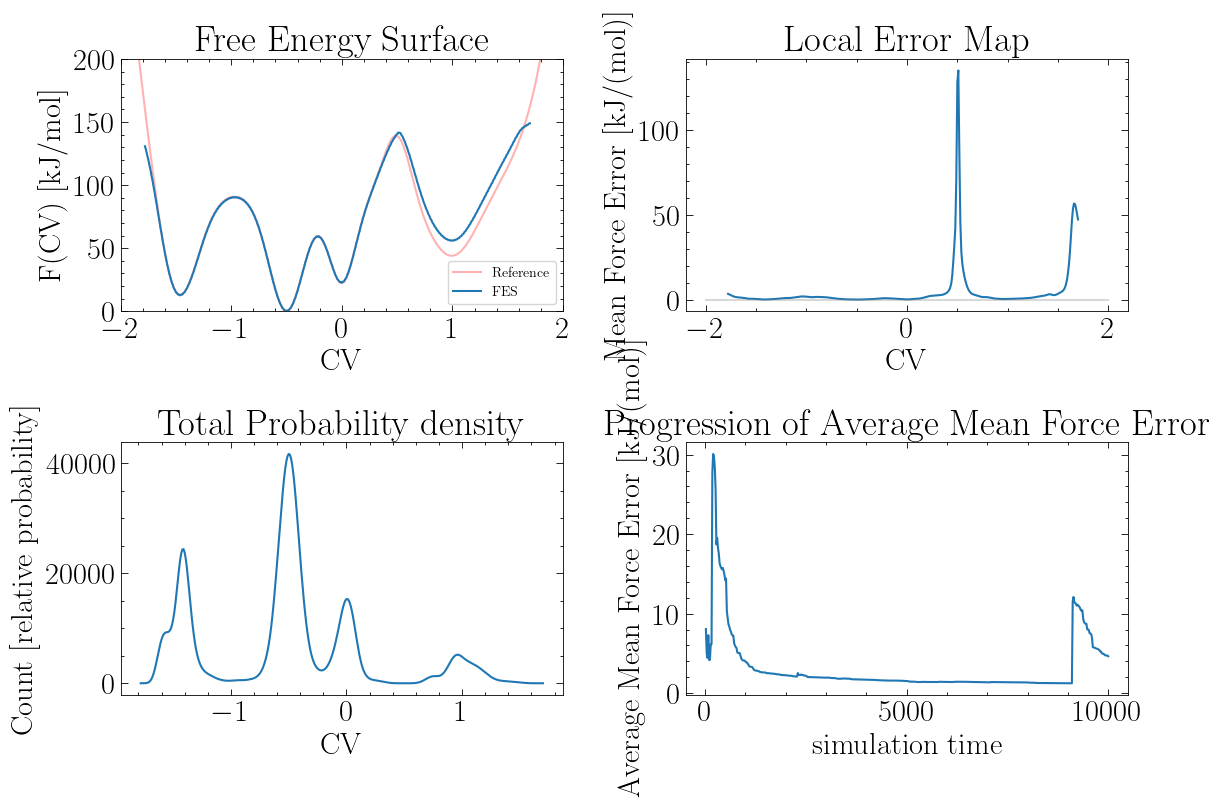

In [4]:
os.chdir(path_manustript + "Figure1A")

#Read the HILLS file
HILLS=MFI1D.load_HILLS(hills_name="HILLS")
# HILLS = HILLS[:int(len(HILLS)/2)]
HILLS_dw=MFI1D.load_HILLS(hills_name="HILLS")

#Read the Colvar File
position = MFI1D.load_position(position_name="position")
# position = position[:int(len(position)/2)]

#Compute the time-independent mean force
# [X, Ftot_den, Ftot, ofv, ofe, ofv_history, ofe_history, time_history, intermediate_fes_list, intermediate_time_list] = MFI1D.MFI_1D_cutoff(HILLS = HILLS, position = position, bw = 0.1, kT = 1, log_pace = 5, error_pace = 100, min_grid=-2.0, max_grid=2.0, WellTempered=1, intermediate_fes_number=100, truncation_limit=10**-5)
# [X, Ftot_den, Ftot, FES, ofv, ofe, ofv_history, ofe_history, time_history, intermediate_fes_list, intermediate_time_list] 

X_dw, Ftot_den_dw, Ftot_den2_dw, Ftot_dw, ofv_num_dw, FES_dw, ofv_dw, ofe_dw, cutoff_dw, error_evol_dw, fes_error_cutoff_evol_dw = MFI1D.MFI_1D(HILLS = HILLS, position = position, bw = 0.03, kT = 1, log_pace = 4000, 
                                                                                                               error_pace = int(len(HILLS)/500), min_grid=-2, max_grid=2, nbins=401, WellTempered=1, FES_cutoff=-1, 
                                                                                                               Ftot_den_cutoff=0.1, save_intermediate_fes_error_cutoff = True, use_weighted_st_dev=False)

# Integrate Ftot, obtain FES 
FES_dw = MFI1D.intg_1D(Ftot_dw, X_dw[1]-X_dw[0])

# Plot Recap
MFI1D.plot_recap(X_dw, MFI1D.zero_to_nan(FES_dw*cutoff_dw), MFI1D.zero_to_nan(Ftot_den_dw*cutoff_dw), MFI1D.zero_to_nan(ofe_dw*cutoff_dw), error_evol_dw[1], error_evol_dw[3], y_ref=y, FES_lim=200, ofe_lim = 0, error_log_scale=0)

### Error plots

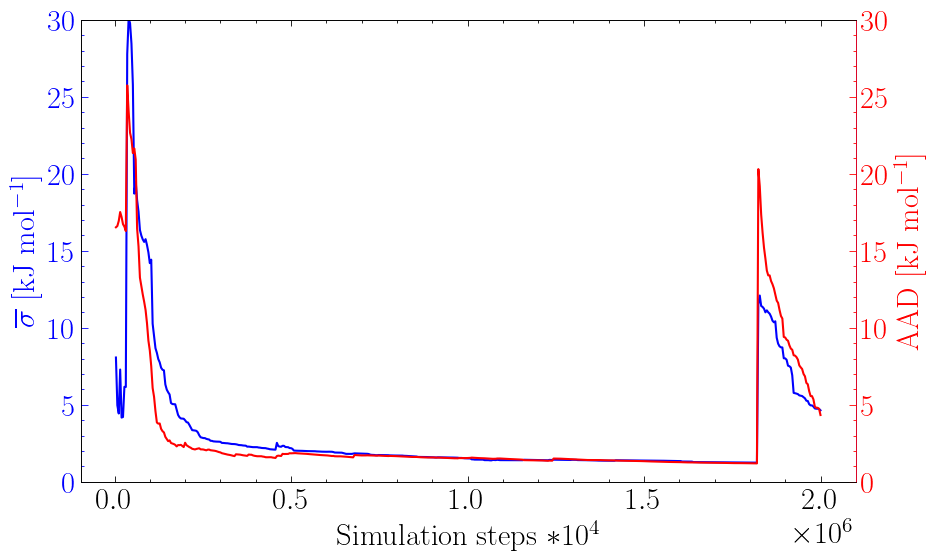

In [8]:
import matplotlib.gridspec as gridspec

aad_evol = []
aad_v_evol = []
for i in range(len(fes_error_cutoff_evol_dw[0])):
    
    FES = fes_error_cutoff_evol_dw[0,i] 
    AD = abs(FES - y) * fes_error_cutoff_evol_dw[3,i]
    AAD = np.sum(AD) / np.count_nonzero(fes_error_cutoff_evol_dw[3,i])
    volume = np.count_nonzero(fes_error_cutoff_evol_dw[3,i]) / len(fes_error_cutoff_evol_dw[3,i])
    aad_evol.append(AAD)
    aad_v_evol.append(AAD / volume)


fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1,1)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = ax1.twinx()

# ax1.plot( error_evol[3] , np.asarray(error_evol[1]) / np.asarray(error_evol[2]) ,color='blue',linewidth=1)
ax1.plot( [ii*200 for ii in error_evol_dw[3]] , np.asarray(error_evol_dw[1])  ,color='blue')#,linewidth=1)
# ax2.plot( error_evol[3], np.asarray(aad_evol) / np.asarray(error_evol[2]) ,color='red',linewidth=1)
ax2.plot( [ii*200 for ii in error_evol_dw[3]], np.asarray(aad_evol)  ,color='red')#,linewidth=1)
ax1.set_xlabel("Simulation steps $*10^4$"); ax1.set_ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]", c="blue"); ax2.set_ylabel("AAD [kJ mol$^{-1}$]", c="red")#ax1.set_title("error/volume vs time"); 
ax1.set_ylim(0,30)
ax2.set_ylim(0,30)
# handles1, labels1 = ax1.get_legend_handles_labels() ; handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
# plt.show()
ax1.tick_params(axis='y', which='both', colors='blue')
ax1.spines['right'].set_color('blue')        # setting up Y-axis tick color to red
ax2.tick_params(axis='y', which='both', colors='red')
ax2.spines['right'].set_color('red')        # setting up Y-axis tick color to red

plt.savefig(path_manustript + "Figure1A/Figure1A_ofe_aad", dpi=300, transparent=True)

454
455
456


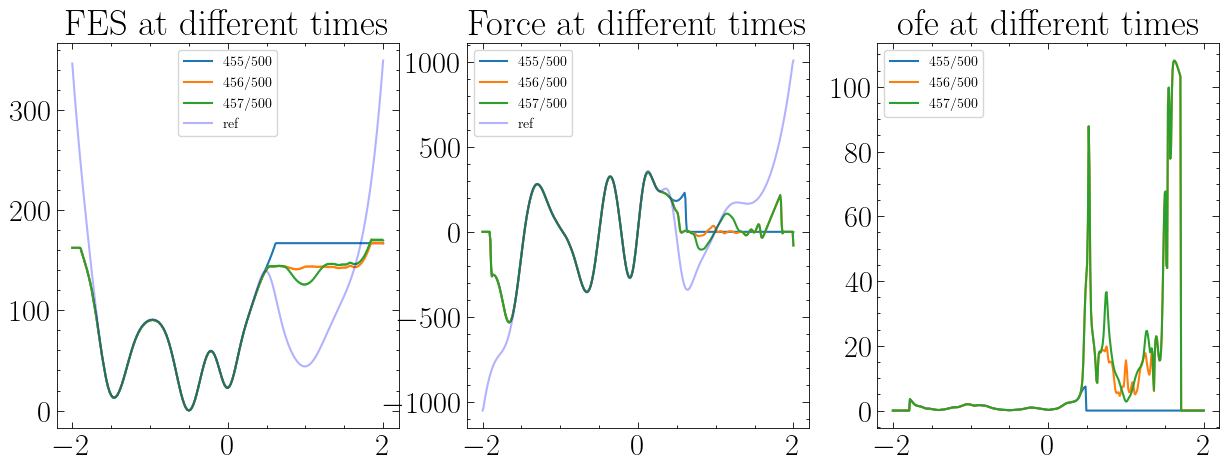

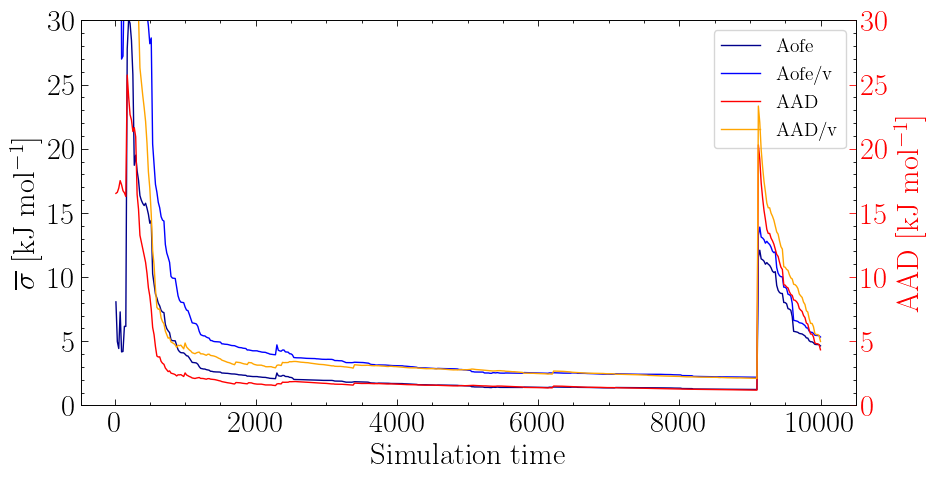

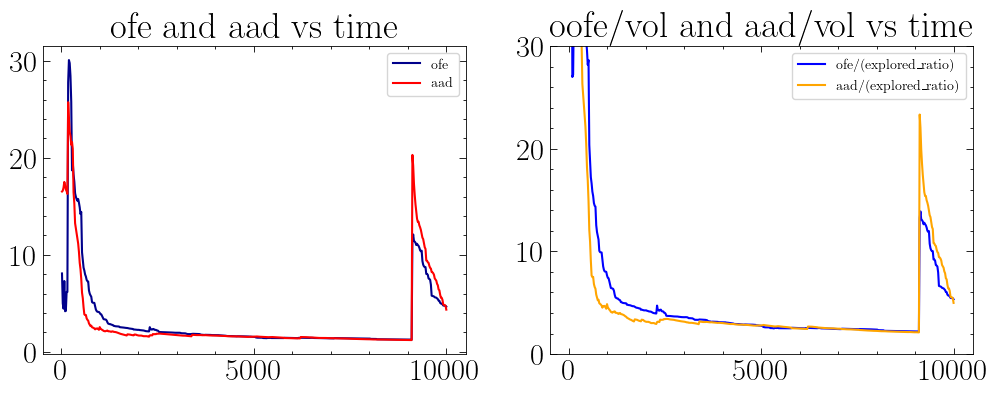

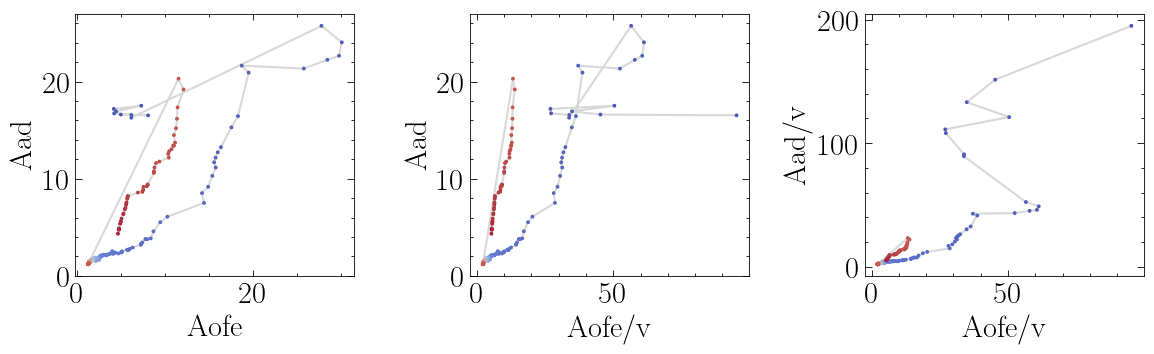

In [9]:
plt.figure(1, figsize=(15,5))
aad_evol = []
aad_v_evol = []
for i in range(len(fes_error_cutoff_evol_dw[0])):
    
    FES = fes_error_cutoff_evol_dw[0,i] 
    AD = abs(FES - y) * fes_error_cutoff_evol_dw[3,i]
    AAD = np.sum(AD) / np.count_nonzero(fes_error_cutoff_evol_dw[3,i])
    volume = np.count_nonzero(fes_error_cutoff_evol_dw[3,i]) / len(fes_error_cutoff_evol_dw[3,i])
    aad_evol.append(AAD)
    aad_v_evol.append(AAD / volume)
    if (i+1) >= 455 and (i+1) <= 457:#and (i+1)%20 == 0:
        print(i)
        plt.figure(1, figsize=(8,4)) 
        plt.subplot(1,3,1)
        plt.plot(x,FES, label=str(i+1)+"/500")
        plt.subplot(1,3,2)
        plt.plot(x,np.gradient(FES,x), label=str(i+1)+"/500")
        plt.subplot(1,3,3)
        plt.plot(x, fes_error_cutoff_evol_dw[2,i], label=str(i+1)+"/500")

plt.figure(1, figsize=(8,4))
plt.subplot(1,3,1)
plt.plot(x,y, c="b", alpha=0.3, label="ref"); plt.title("FES at different times"); plt.legend(fontsize=10)
plt.subplot(1,3,2)
plt.plot(x,np.gradient(y,x), c="b", alpha=0.3, label="ref"); plt.title("Force at different times"); plt.legend(fontsize=10)
plt.subplot(1,3,3)
plt.legend(fontsize=10); plt.title("ofe at different times")
plt.show()



fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.plot( error_evol_dw[3], error_evol_dw[1], c="darkblue",linewidth=1,label="Aofe")
ax1.plot( error_evol_dw[3], error_evol_dw[1]/error_evol_dw[2] ,c='blue',linewidth=1,label="Aofe/v")
ax2.plot( error_evol_dw[3], aad_evol, c="red" ,linewidth=1,label="AAD")
ax2.plot( error_evol_dw[3], aad_evol/error_evol_dw[2],c="orange",linewidth=1, label="AAD/v")
# ax2.plot([1511,1511], [0.8,4], c="grey", label="Exploration of 2nd Basin")

ax1.set_xlabel("Simulation time"); ax1.set_ylabel("$\overline{\sigma}$ [kJ mol$^{-1}$]", c="black"); ax2.set_ylabel("AAD [kJ mol$^{-1}$]", c="red"); ax2.tick_params('y', colors='r')
ax1.set_ylim(0,30) ;ax2.set_ylim(0,30)

handles1, labels1 = ax1.get_legend_handles_labels(); handles2, labels2 = ax2.get_legend_handles_labels(); ax1.legend(handles1 + handles2, labels1 + labels2, fontsize=14)
plt.show()



plt.figure(3, figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(error_evol_dw[3], error_evol_dw[1], c="darkblue", label="ofe")
# plt.scatter(error_evol[3], error_evol[1], c="darkblue",s=3)
plt.plot(error_evol_dw[3], aad_evol, label="aad",c="red")
# plt.scatter(error_evol[3], aad_evol,s=3,c="red")
plt.title("ofe and aad vs time"); plt.legend(fontsize=10); 

plt.subplot(1,2,2)
plt.plot(error_evol_dw[3], error_evol_dw[1]/error_evol_dw[2], c="blue", label="ofe/(explored_ratio)")
# plt.scatter(error_evol[3], error_evol[1]/error_evol[2], c="blue",s=3)
plt.plot(error_evol_dw[3], aad_evol/error_evol_dw[2], label="aad/(explored_ratio)",c="orange")
# plt.scatter(error_evol[3], aad_v_evol,s=3,c="orange")
plt.title("oofe/vol and aad/vol vs time"); plt.legend(fontsize=10); 
plt.ylim(0,30)
plt.show()

plt.figure(3, figsize=(12,4))
plt.subplot(1,3,1)
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, len(aad_evol))
plt.scatter(error_evol_dw[1], aad_evol ,s=3, c=range(len(aad_evol)), cmap=cmap, norm=norm)
plt.plot(error_evol_dw[1], aad_evol, c="grey", alpha=0.3); #plt.title("ofe vs. AAD evol")#; plt.show()#; plt.yscale("log"); plt.xscale("log")
plt.xlabel("Aofe"); plt.ylabel("Aad")

plt.subplot(1,3,2)
plt.scatter(error_evol_dw[1]/error_evol_dw[2], aad_evol ,s=3, c=range(len(aad_evol)), cmap="coolwarm", norm=norm)
plt.plot(error_evol_dw[1]/error_evol_dw[2], aad_evol, c="grey", alpha=0.3); #plt.title("ofe/vol vs. AAD evol")#; plt.show()#; plt.yscale("log"); plt.xscale("log")
plt.xlabel("Aofe/v"); plt.ylabel("Aad")

plt.subplot(1,3,3)
plt.scatter(error_evol_dw[1]/error_evol_dw[2], aad_v_evol ,s=3, c=range(len(aad_evol)), cmap="coolwarm", norm=norm)
plt.plot(error_evol_dw[1]/error_evol_dw[2], aad_v_evol, c="grey", alpha=0.3); plt.xlabel("Aofe/v"); plt.ylabel("Aad/v");# plt.title("ofe/vol vs. AAD/vol evol")
plt.tight_layout(); plt.show()#; plt.yscale("log"); plt.xscale("log")
    

### paper plot

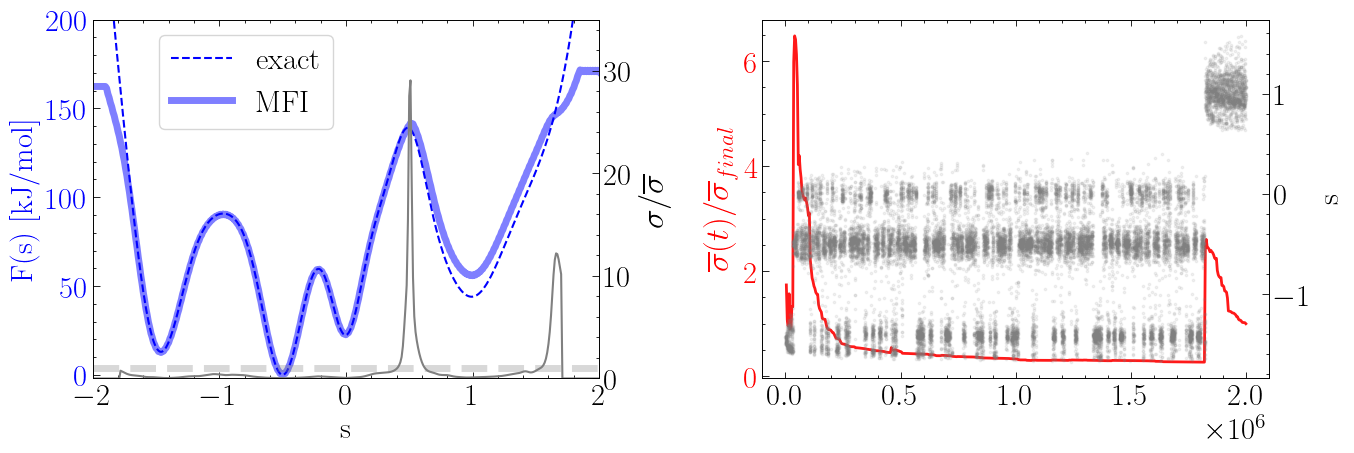

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

#Left plot
axs[0].set_ylabel('F(s) [kJ/mol]',color='blue')
axs[0].set_xlabel('s')
axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,200)
axs[0].plot(x, y-min(y),'--',color='blue',label='exact');
axs[0].plot(X_dw, FES_dw,color='blue',linewidth=5,alpha=0.5,label="MFI");
axs[0].tick_params(axis ='y', labelcolor = 'blue')

ax1 = axs[0].twinx()
ax1.set_ylabel('$\sigma/\overline{\sigma}$', fontsize=24, color='black')
ax1.tick_params(axis ='y', labelcolor = 'black', right = True , labelright = True ) 
ax1.set_ylim([0, 35] ) 
# ax1.set_yscale("log")
# ax1.plot(X_dw, ofe_dw*cutoff_dw/np.mean((ofe_dw)*cutoff_dw),color="grey",label="$\sigma^2(s)$");
ax1.plot(X_dw, ofe_dw*cutoff_dw / (np.sum(ofe_dw*cutoff_dw) / np.count_nonzero(cutoff_dw)),color="grey",label="$\sigma^2(s)$");
ax1.plot(X_dw, np.zeros(len(X_dw))+1,'--',linewidth=5,color="grey", alpha=0.3,label="$\overline{\sigma^2(s)}$");
axs[0].legend(loc='upper left', bbox_to_anchor=(0.1, 1))

#Right plot
ax2 = axs[1].twinx()

axs[1].plot([time/0.005 for time in error_evol_dw[3]], error_evol_dw[1]/error_evol_dw[1][np.size(error_evol_dw[1])-1],color='red',linewidth=2,alpha=0.9);
axs[1].set_ylabel('$\overline{\sigma}(t)/\overline{\sigma}_{final}$', fontsize=24, color='red')
axs[1].tick_params(axis ='y', labelcolor = 'red')
ax2.set_xlabel('Simulation steps')
ax2.set_ylabel('s',color='black')
ax2.tick_params(axis ='y', labelcolor = 'black')
ax2.scatter(HILLS[:,0]/0.005,HILLS[:,1],color='grey',s=3, alpha=0.1)

fig.tight_layout()    

# plt.savefig('Figure1A', dpi=600, bbox_inches='tight')


### alanine dipeptide

In [6]:
# load ref surface 40M
os.chdir(path_manustript + "Figure1B")
FES_ref = MFI.load_pkl("AD_ref_fes")

In [7]:
def MFI_2D(HILLS="HILLS", position_x="position_x", position_y="position_y", bw = np.array((0.1,0.1)), kT=1,
			min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), nbins=np.array((200, 200)),
			error_pace=-1, base_terms = 0, window_corners=[], WellTempered=1, nhills=-1, periodic = np.array((0,0)), 
			Ftot_den_limit = 1E-10, FES_cutoff = -1, Ftot_den_cutoff = 0.1, non_exploration_pentaly=-1, use_weighted_st_dev = True,
			hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=0, hp_kappa_y=0,
			lw_centre_x=0.0, lw_centre_y=0.0, lw_kappa_x=0, lw_kappa_y=0,
			uw_centre_x=0.0, uw_centre_y=0.0, uw_kappa_x=0, uw_kappa_y=0, ref_fes = np.zeros((200,200))):
	"""Compute a time-independent estimate of the Mean Thermodynamic Force, i.e. the free energy gradient in 2D CV spaces.

	Args:
		HILLS (str): HILLS array. Defaults to "HILLS".
		position_x (str): CV1 array. Defaults to "position_x".
		position_y (str): CV2 array. Defaults to "position_y".
		bw (int, optional): Scalar, bandwidth for the construction of the KDE estimate of the biased probability density. Defaults to 1.
		kT (int, optional): Scalar, kT. Defaults to 1.
		min_grid (array, optional): Lower bound of the force domain. Defaults to np.array((-np.pi, -np.pi)).
		max_grid (array, optional): Upper bound of the force domain. Defaults to np.array((np.pi, np.pi)).
		nbins (array, optional): number of bins in CV2,CV1. First enrty is the number of bins in CV2 and the second entry is the number of bins in CV1! Defaults to np.array((200,200)). 
		error_pace (int, optional): Pace for the calculation of the on-the-fly measure of global convergence. Defaults to 1, change it to a higher value if FES_cutoff>0 is used. 
		base_terms (int or list, optional): When set to 0, inactive. When activated, "on the fly" variance is calculated as a patch to base (previous) simulation. To activate, put force terms of base simulation ([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]). Defaults to 0.
		window_corners (list, optional): When set to [], inactive. When activated, error is ALSO calculated for mean force in the window. To activate, put the min and max values of the window ([min_x, max_x, min_y, max_y]). Defaults to [].
		WellTempered (binary, optional): Is the simulation well tempered? . Defaults to 1.
		nhills (int, optional): Number of HILLS to analyse, -1 for the entire HILLS array. Defaults to -1, i.e. the entire dataset.
		periodic (int, optional): Is the CV space periodic? 1 for yes. Defaults to 0.
		Ftot_den_limit (float, optional): Truncation of the probability density for numerical reasons, to avaiod devisions by zero (or suare root of negative numbers). If the probability density (Ftot_den) of some CV region is lover than the Ftot_den_limit, it will be set to zero. Default is set to 1E-10.
		FES_cutoff (float, optional): Cutoff applied to error calculation for FES values over the FES_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0. When FES_cutoff <= 0, no cufoff is applied. Use with care, computing the fes in the loop renders the calculation slow.
		Ftot_den_cutoff (float, optional): Cutoff applied to error calculation for probability density (Ftot_den) values below the Ftot_den_cutoff. If the cutoff applies, the error will be set to zero, otherwise the error will stay the same. Defaults to 0.1. When Ftot_den_cutoff <= 0, no cufoff is applied. 
		non_exploration_penalty (float, optional): Turns zero-value error to the non_exploration_penalty value. This should be used in combination with the cutoff. If some part of CV space hasn't been explored, or has a FES value that is irrelevanlty high, the cutoff will set the error of that region to zero. If the non_exploration_penalty is larger than zero, the error of that region will take the value of the non_exploration_penalty instead of zero. Default is set to 0.
		hp_centre_x (float, optional): CV1-position of harmonic potential. Defaults to 0.0.
		hp_centre_y (float, optional): CV2-position of harmonic potential. Defaults to 0.0.
		hp_kappa_x (int, optional): CV1-force_constant of harmonic potential. Defaults to 0.
		hp_kappa_y (int, optional): CV2-force_constant of harmonic potential. Defaults to 0.
		lw_centre_x (float, optional): CV1-position of lower wall potential. Defaults to 0.0.
		lw_centre_y (float, optional): CV2-position of lower wall potential. Defaults to 0.0.
		lw_kappa_x (int, optional): CV1-force_constant of lower wall potential. Defaults to 0.
		lw_kappa_y (int, optional): CV2-force_constant of lower wall potential. Defaults to 0.
		uw_centre_x (float, optional): CV1-position of upper wall potential. Defaults to 0.0.
		uw_centre_y (float, optional): CV2-position of upper wall potential. Defaults to 0.0.
		uw_kappa_x (int, optional): CV1-force_constant of upper wall potential. Defaults to 0.
		uw_kappa_y (int, optional): CV2-force_constant of upper wall potential. Defaults to 0.

	Returns:
		X: array of size (nbins[0], nbins[1]) - CV1 grid positions
		Y: array of size (nbins[0], nbins[1]) - CV2 grid positions
		Ftot_den: array of size (nbins[0], nbins[1]) - Cumulative biased probability density, equivalent to an unbiased histogram of samples in CV space.
		Ftot_x:  array of size (nbins[0], nbins[1]) - CV1 component of the Mean Force.
		Ftot_y:  array of size (nbins[0], nbins[1]) - CV2 component of the Mean Force.
		ofe:  array of size (nbins[0], nbins[1]) - on the fly estimate of the local convergence
		ofe_history: array of size (1, total_number_of_hills) - running estimate of the global convergence of the mean force.
		(option with window corner activated: ofe_history_window: array of size (1, total_number_of_hills) - running estimate of the "window" convergence of the mean force.)
		ofe_history_time: array of size (1, total_number_of_hills) - time array of ofe_history
		Ftot_den2: array of size (nbins[0], nbins[1]) - Cumulative squared biased probability density
		ofv_x: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV1 "on the fly variance" ( sum of: pb_t * dfds_x ** 2)
		ofv_y: array of size (nbins[0], nbins[1]) - intermediate component in the calculation of the CV2 "on the fly variance" ( sum of: pb_t * dfds_y ** 2)
	"""

	gridx = np.linspace(min_grid[0], max_grid[0], nbins[1])
	gridy = np.linspace(min_grid[1], max_grid[1], nbins[0])
	grid_space = np.array(((max_grid[0] - min_grid[0]) / (nbins[1]-1), (max_grid[1] - min_grid[1]) / (nbins[0]-1)))
	X, Y = np.meshgrid(gridx, gridy)
	stride = int(len(position_x) / len(HILLS))
	bw_xy = np.sqrt(bw[0] * bw[1])
	bw_xy2  = bw_xy ** 2
	bw_x2 = bw[0] ** 2
	bw_y2 = bw[1] ** 2
	const = (1 / (bw_xy * np.sqrt(2 * np.pi) * stride))

	# Optional - analyse only nhills, if nhills is set
	if nhills > 0: total_number_of_hills = nhills
	else: total_number_of_hills = len(HILLS)
	if error_pace == -1: error_pace = int(total_number_of_hills / 100)
	elif error_pace == -2: error_pace = int(total_number_of_hills / 10)
	elif error_pace < 0: error_pace = total_number_of_hills
	if FES_cutoff > 0: FES_cutoff = [FES_cutoff, min_grid, max_grid, periodic]
 
	# Initialize force terms
	Fbias_x = np.zeros(nbins)
	Fbias_y = np.zeros(nbins)
	Ftot_num_x = np.zeros(nbins)
	Ftot_num_y = np.zeros(nbins)
	Ftot_den = np.zeros(nbins)
	Ftot_den2 = np.zeros(nbins)
	ofv_num_x = np.zeros(nbins)
	ofv_num_y = np.zeros(nbins)
	cutoff = np.ones(nbins)
	volume_history = []
	ofe_history = []
	aad_history = []
	time_history = []
	all_ofe = []
	all_aad = []
	if len(window_corners) == 4: ofe_history_window = []

	#Calculate static force
	F_static_x = np.zeros(nbins)
	F_static_y = np.zeros(nbins)
	if hp_kappa_x > 0 or hp_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_hp_force(hp_centre_x, hp_centre_y, hp_kappa_x, hp_kappa_y, X , Y, min_grid, max_grid, grid_space, periodic)
		F_static_x += Force_x
		F_static_y += Force_y
	if lw_kappa_x > 0 or lw_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_lw_force(lw_centre_x, lw_centre_y, lw_kappa_x, lw_kappa_y, X , Y, periodic)
		F_static_x += Force_x
		F_static_y += Force_y
	if uw_kappa_x > 0 or uw_kappa_y > 0:
		[Force_x, Force_y] = MFI.find_uw_force(uw_centre_x, uw_centre_y, uw_kappa_x, uw_kappa_y, X , Y, periodic)
		F_static_x += Force_x
		F_static_y += Force_y

	# Definition Gamma Factor, allows to switch between WT and regular MetaD
	if WellTempered < 1: Gamma_Factor = 1
	else: Gamma_Factor = (HILLS[0, 6] - 1) / (HILLS[0, 6])
		
	for i in range(total_number_of_hills):
		
		# Build metadynamics potential
		s_x = HILLS[i, 1]  # centre x-position of Gaussian
		s_y = HILLS[i, 2]  # centre y-position of Gaussian
		sigma_meta2_x = HILLS[i, 3] ** 2  # width of Gaussian
		sigma_meta2_y = HILLS[i, 4] ** 2  # width of Gaussian
		height_meta = HILLS[i, 5] * Gamma_Factor  # Height of Gaussian

		periodic_images = MFI.find_periodic_point(s_x, s_y, min_grid, max_grid, periodic)
		for j in range(len(periodic_images)):
			kernelmeta_x = np.exp( - np.square(gridx - periodic_images[j][0]) / (2 * sigma_meta2_x)) * height_meta
			kernelmeta_y = np.exp( - np.square(gridy - periodic_images[j][1]) / (2 * sigma_meta2_y))
			Fbias_x += np.outer(kernelmeta_y, np.multiply(kernelmeta_x, (gridx - periodic_images[j][0])) / sigma_meta2_x )
			Fbias_y += np.outer(np.multiply(kernelmeta_y, (gridy - periodic_images[j][1])) / sigma_meta2_y, kernelmeta_x )

		# Estimate the biased proabability density p_t ^ b(s)
		pb_t = np.zeros(nbins)
		Fpbt_x = np.zeros(nbins)
		Fpbt_y = np.zeros(nbins)

		data_x = position_x[i * stride: (i + 1) * stride]
		data_y = position_y[i * stride: (i + 1) * stride]

		for j in range(stride):
			periodic_images = MFI.find_periodic_point(data_x[j], data_y[j], min_grid, max_grid, periodic)
			for k in range(len(periodic_images)):
				kernel_x = np.exp( - np.square(gridx - periodic_images[k][0]) / (2 * bw_x2)) * const #add constant here for less computations
				kernel_y = np.exp( - np.square(gridy - periodic_images[k][1]) / (2 * bw_y2))
				kernel = np.outer(kernel_y, kernel_x)
				kernel_x *= kT / bw_xy2 #add constant here for less computations

				pb_t += kernel
				Fpbt_x += np.outer(kernel_y, np.multiply(kernel_x, (gridx - periodic_images[k][0])) )
				Fpbt_y += np.outer(np.multiply(kernel_y, (gridy - periodic_images[k][1])) , kernel_x )

		# Calculate total probability density
		pb_t = np.where(pb_t > Ftot_den_limit, pb_t, 0)  # truncated probability density of window
		Ftot_den += pb_t
		
		# Calculate x-component of Force
		dfds_x = np.divide(Fpbt_x, pb_t, out=np.zeros_like(Fpbt_x), where=pb_t > 0) + Fbias_x - F_static_x
		Ftot_num_x += np.multiply(pb_t, dfds_x)
		
		# Calculate y-component of Force
		dfds_y = np.divide(Fpbt_y, pb_t, out=np.zeros_like(Fpbt_y), where=pb_t > 0) + Fbias_y - F_static_y
		Ftot_num_y += np.multiply(pb_t, dfds_y)

		# calculate on the fly error components
		Ftot_den2 += np.square(pb_t)
		ofv_num_x += np.multiply(pb_t, np.square(dfds_x))
		ofv_num_y += np.multiply(pb_t, np.square(dfds_y))

		if (i + 1) % int(error_pace) == 0 or (i+1) == total_number_of_hills:
			#calculate forces
			Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den > 0)
			Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den > 0)

			# calculate ofe (standard error)
			if base_terms == 0:
				[ofv, ofe] = MFI.mean_force_variance(Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y, use_weighted_st_dev=use_weighted_st_dev)
				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot] = [np.array(Ftot_den), np.array(Ftot_x), np.array(Ftot_y)]
			elif len(base_terms) == 6:
				[Ftot_den_tot, Ftot_x_tot, Ftot_y_tot, ofv, ofe] = MFI.patch_to_base_variance(base_terms, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])

			# If specified, apply cutoff to error and/or non_exploration_pentaly
			if Ftot_den_cutoff > 0 or hasattr(FES_cutoff, "__len__"): cutoff = MFI.get_cutoff(Ftot_den_tot, Ftot_den_cutoff=Ftot_den_cutoff, FX=Ftot_x_tot, FY=Ftot_y_tot, FES_cutoff=FES_cutoff)			
			if non_exploration_pentaly > 0: ofe = np.where(cutoff > 0.5, ofe, non_exploration_pentaly)
			else: ofe *= cutoff
   
			# ofe = np.where(ref_fes < 19, ofe, 0)

			#Calculate averaged global error
			absolute_explored_volume = np.count_nonzero(cutoff)
			# if i ==0: print("ofe is cut where inve_Pot < 19")
			volume_history.append( absolute_explored_volume/(nbins[0]*nbins[1]))
			if non_exploration_pentaly <= 0: ofe_history.append( np.sum(ofe) / absolute_explored_volume)
			else: ofe_history.append( np.sum(ofe) / (nbins[0]*nbins[1]))
			time_history.append(HILLS[i,0] + HILLS[2,0] - HILLS[1,0])
			if len(window_corners) == 4:
				ofe_cut_window = MFI.reduce_to_window(ofe, min_grid, grid_space, x_min=window_corners[0], x_max=window_corners[1], y_min=window_corners[2], y_max=window_corners[3]) 
				ofe_history_window.append(np.sum(ofe_cut_window) / (np.count_nonzero(ofe_cut_window)))
    
    
			#Find Absolute devaition
			[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x_tot, Ftot_y_tot, min_grid=min_grid, max_grid=max_grid)
			AD = abs(ref_fes - FES)
			ADc = AD * cutoff
			# ADc = np.where(ref_fes < 19, ADc, 0)
			AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
			AADc = np.sum(ADc)/(np.count_nonzero(ADc))
			aad_history.append([AAD,AADc])

			for ii in range(len(ofe)):
				for jj in range(len(ofe[0])):
        
					if ofe[ii][jj] != 0: 
						all_ofe.append(ofe[ii][jj])
						all_aad.append(ADc[ii][jj])

			#print progress
			MFI.print_progress(i+1,total_number_of_hills,variable_name='Average Mean Force Error',variable=round(ofe_history[-1],3))        
			# if len(window_corners) == 4: print("    ||    Error in window", ofe_history_window[-1])		

			
	if len(window_corners) == 4: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
  
	else: return [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y, all_ofe, all_aad]



In [15]:
os.chdir(path_manustript + "Figure1B")

# #Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")

# #Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

# #Compute the time-independent mean force
NH=10000
start=time.time()
results = MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.1,0.1)), kT = 2.49, error_pace=int(NH/2000), WellTempered=1, nhills=NH, periodic = np.array((1,1)), ref_fes=FES_ref, use_weighted_st_dev=False)
end=time.time()
print("Time taken for MFI algorithm: ", round(time.time()-start,3), "s")

# [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y, all_ofe, all_aad] = results

# #integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), periodic = np.array((1,1)))

#Find Absolute devaition
AD = abs(FES_ref - FES) 
ADc = AD * cutoff
# ADc = np.where(FES_ref < 30, ADc, 0)
AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("AAD =" ,round(AAD,2) , "   |    AAD_(where pd>0.1) =", round(AADc,2))

[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1, volume_history_1] = [FES, Ftot_den, ofe, ADc, cutoff, time_history, ofe_history, aad_history, volume_history]


|**************************************************| 100% | Average Mean Force Error: 4.963Time taken for MFI algorithm:  133.206 s
AAD = 2.32    |    AAD_(where pd>0.1) = 0.79


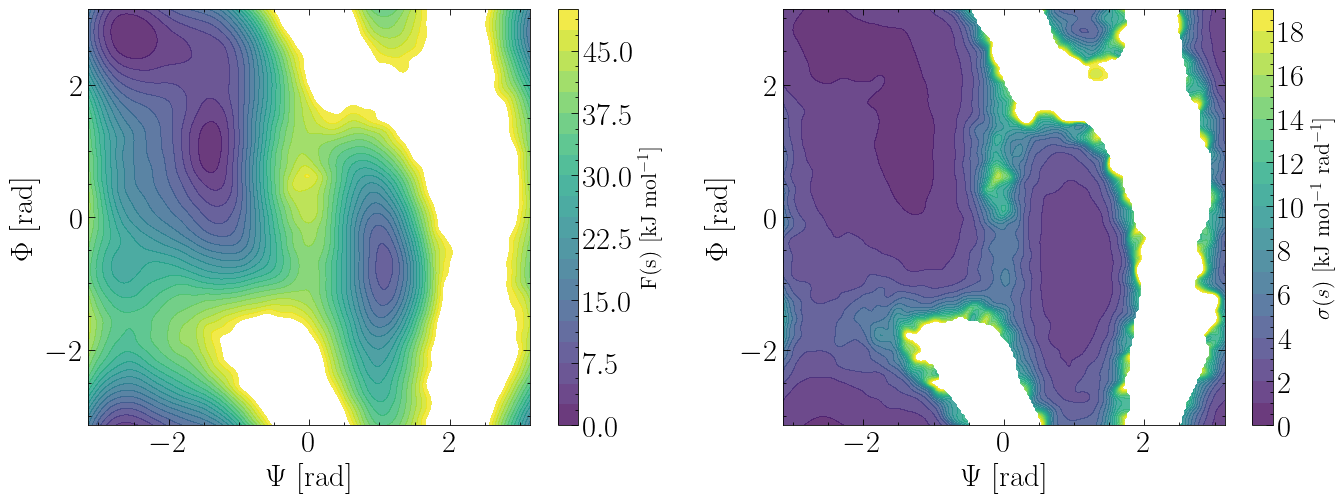

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5.5))
cp = axs[0].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[0])
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs[0].set_ylabel('$\Phi$ [rad]')
axs[0].set_xlabel('$\Psi$ [rad]')
axs[0].set_xlim(np.min(X),np.max(X))
axs[0].set_ylim(np.min(Y),np.max(Y))


cp = axs[1].contourf(X, Y, MFI.zero_to_nan(ofe*cutoff), levels=np.arange(0, 20, 1), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1])
cbar.set_label("$\sigma(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16)
axs[1].set_ylabel('$\Phi$ [rad]')
axs[1].set_xlabel('$\Psi$ [rad]')
axs[1].set_xlim(np.min(X),np.max(X))
axs[1].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()   


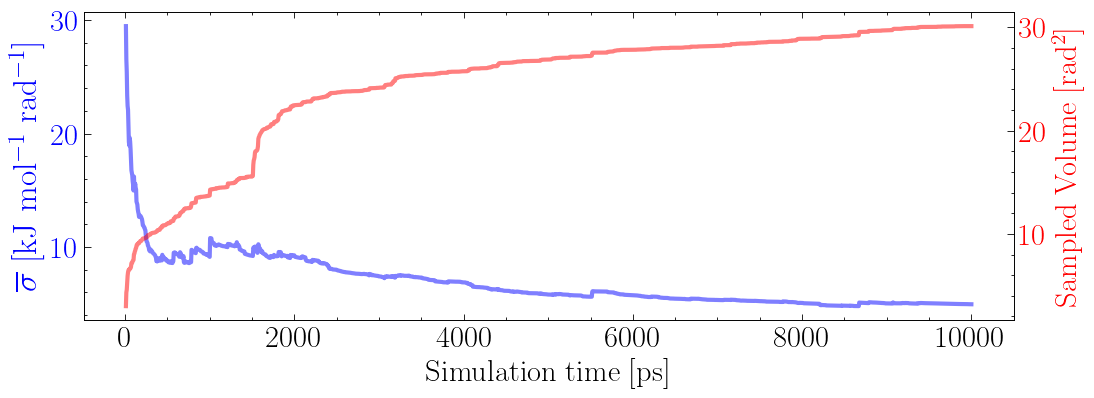

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot( [time for time in time_history[1:]], (ofe_history[1:NH]),color='blue',alpha=0.5,linewidth=3);
axs.set_ylabel('$\overline{\sigma}$ [kJ mol$^{-1}$ rad$^{-1}$]',fontsize=24, color='blue')
axs.tick_params(axis ='y', labelcolor = 'blue')
axs.set_xlabel('Simulation time [ps]')

V=np.multiply(volume_history[1:NH],np.power(2*np.pi,2))
ax2 = axs.twinx()
ax2.set_xlabel('Simulation steps')
ax2.set_ylabel('Sampled Volume [rad$^2$]',color='red')
ax2.tick_params(axis ='y', labelcolor = 'red')
ax2.plot( [time for time in time_history[1:]], np.multiply(volume_history[1:NH],np.power(2*np.pi,2)),color='red',alpha=0.5,linewidth=3);

# plt.savefig('Figure1B_2', dpi=600, bbox_inches='tight')

|**************************************************| 100% | Average Mean Force Error: 30.25

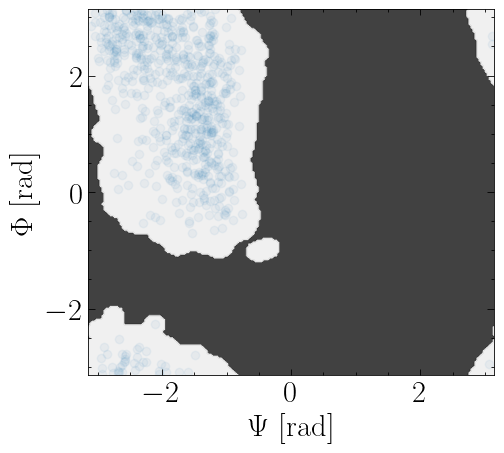

|**************************************************| 100% | Average Mean Force Error: 30.479

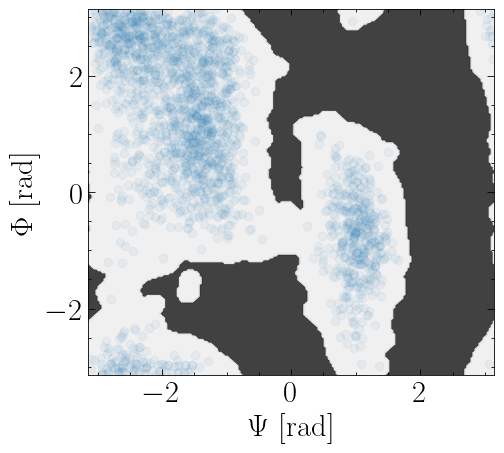

|**************************************************| 100% | Average Mean Force Error: 29.971

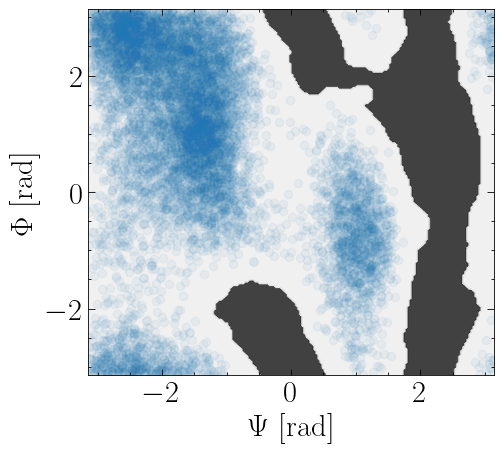

In [13]:
for NH in [700, 2200, 9400]:

    results_temp = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.1,0.1)), kT = 2.49, error_pace = 100, WellTempered=1, nhills=NH, periodic = np.array((1,1)))
    [X, Y, Ftot_den_temp, Ftot_x_temp, Ftot_y_temp, ofv_temp, ofe_temp, cutoff_temp, volume_history_temp, ofe_history_temp, aad_history_temp, time_history_temp, Ftot_den2_temp, ofv_num_x_temp, ofv_num_y_temp] = results_temp

    fig, axs = plt.subplots(1, 1, figsize=(5.5, 5))

    cp = axs.contourf(X, Y, cutoff_temp, cmap='gray', antialiased=False, alpha=0.8);
    # cbar = plt.colorbar(cp, ax=axs)
    # cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
    axs.set_ylabel('$\Phi$ [rad]')
    axs.set_xlabel('$\Psi$ [rad]')
    axs.set_xlim(np.min(X),np.max(X))
    axs.set_ylim(np.min(Y),np.max(Y))

    cp=axs.scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
    # cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
    axs.set_ylabel('$\Phi$ [rad]')
    axs.set_xlabel('$\Psi$ [rad]')
    axs.set_xlim(np.min(X),np.max(X))
    axs.set_ylim(np.min(Y),np.max(Y))

    fig.tight_layout()
    plt.show()
    
    if NH == 700: cutoff_700 = cutoff_temp
    if NH == 2200: cutoff_2200 = cutoff_temp
    if NH == 9400: cutoff_9400 = cutoff_temp

# plt.savefig('Figure1B_3', dpi=600, bbox_inches='tight')

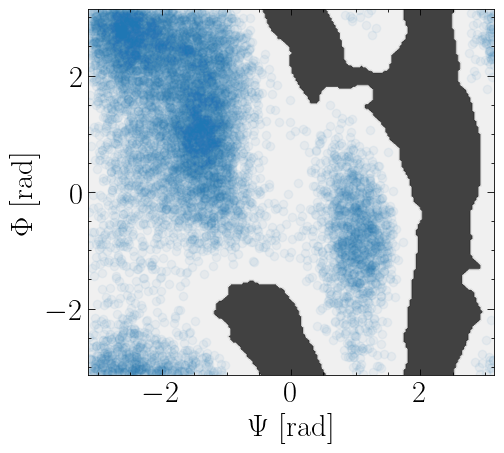

In [55]:
NH = 9400
fig, axs = plt.subplots(1, 1, figsize=(5.5, 5))

cp = axs.contourf(X, Y, cutoff_temp, cmap='gray', antialiased=False, alpha=0.8);
# cbar = plt.colorbar(cp, ax=axs)
# cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

# cp=axs.scatter(HILLS[NH-50:NH,1],HILLS[NH-50:NH,2],alpha=0.05);
cp=axs.scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
# cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
axs.set_ylabel('$\Phi$ [rad]')
axs.set_xlabel('$\Psi$ [rad]')
axs.set_xlim(np.min(X),np.max(X))
axs.set_ylim(np.min(Y),np.max(Y))

fig.tight_layout()
plt.show()


In [46]:
data_figure_1 = [x, y, X_dw, FES_dw, ofe_dw, cutoff_dw, error_evol_dw, HILLS_dw, X,Y, FES_1, ofe_1, cutoff_1, time_history, ofe_history, volume_history, HILLS, cutoff_700, cutoff_2200, cutoff_9400]
MFI.save_pkl(data_figure_1, path_manustript + "Figure1/data_figure_1.pkl")

# data_figure_1 = MFI.load_pkl("data_figure_1.pkl")
# [x, y, X_dw, FES_dw, ofe_dw, cutoff_dw, error_evol_dw, HILLS_dw, X,Y, FES_1, ofe_1, cutoff_1, time_history, ofe_history, volume_history, HILLS, cutoff_700, cutoff_2200, cutoff_9400] = data_figure_1


In [44]:
path_manustript + "Figure1A/"

'/home/ucecabj/Desktop/MFI_git/Manuscript_Results/'

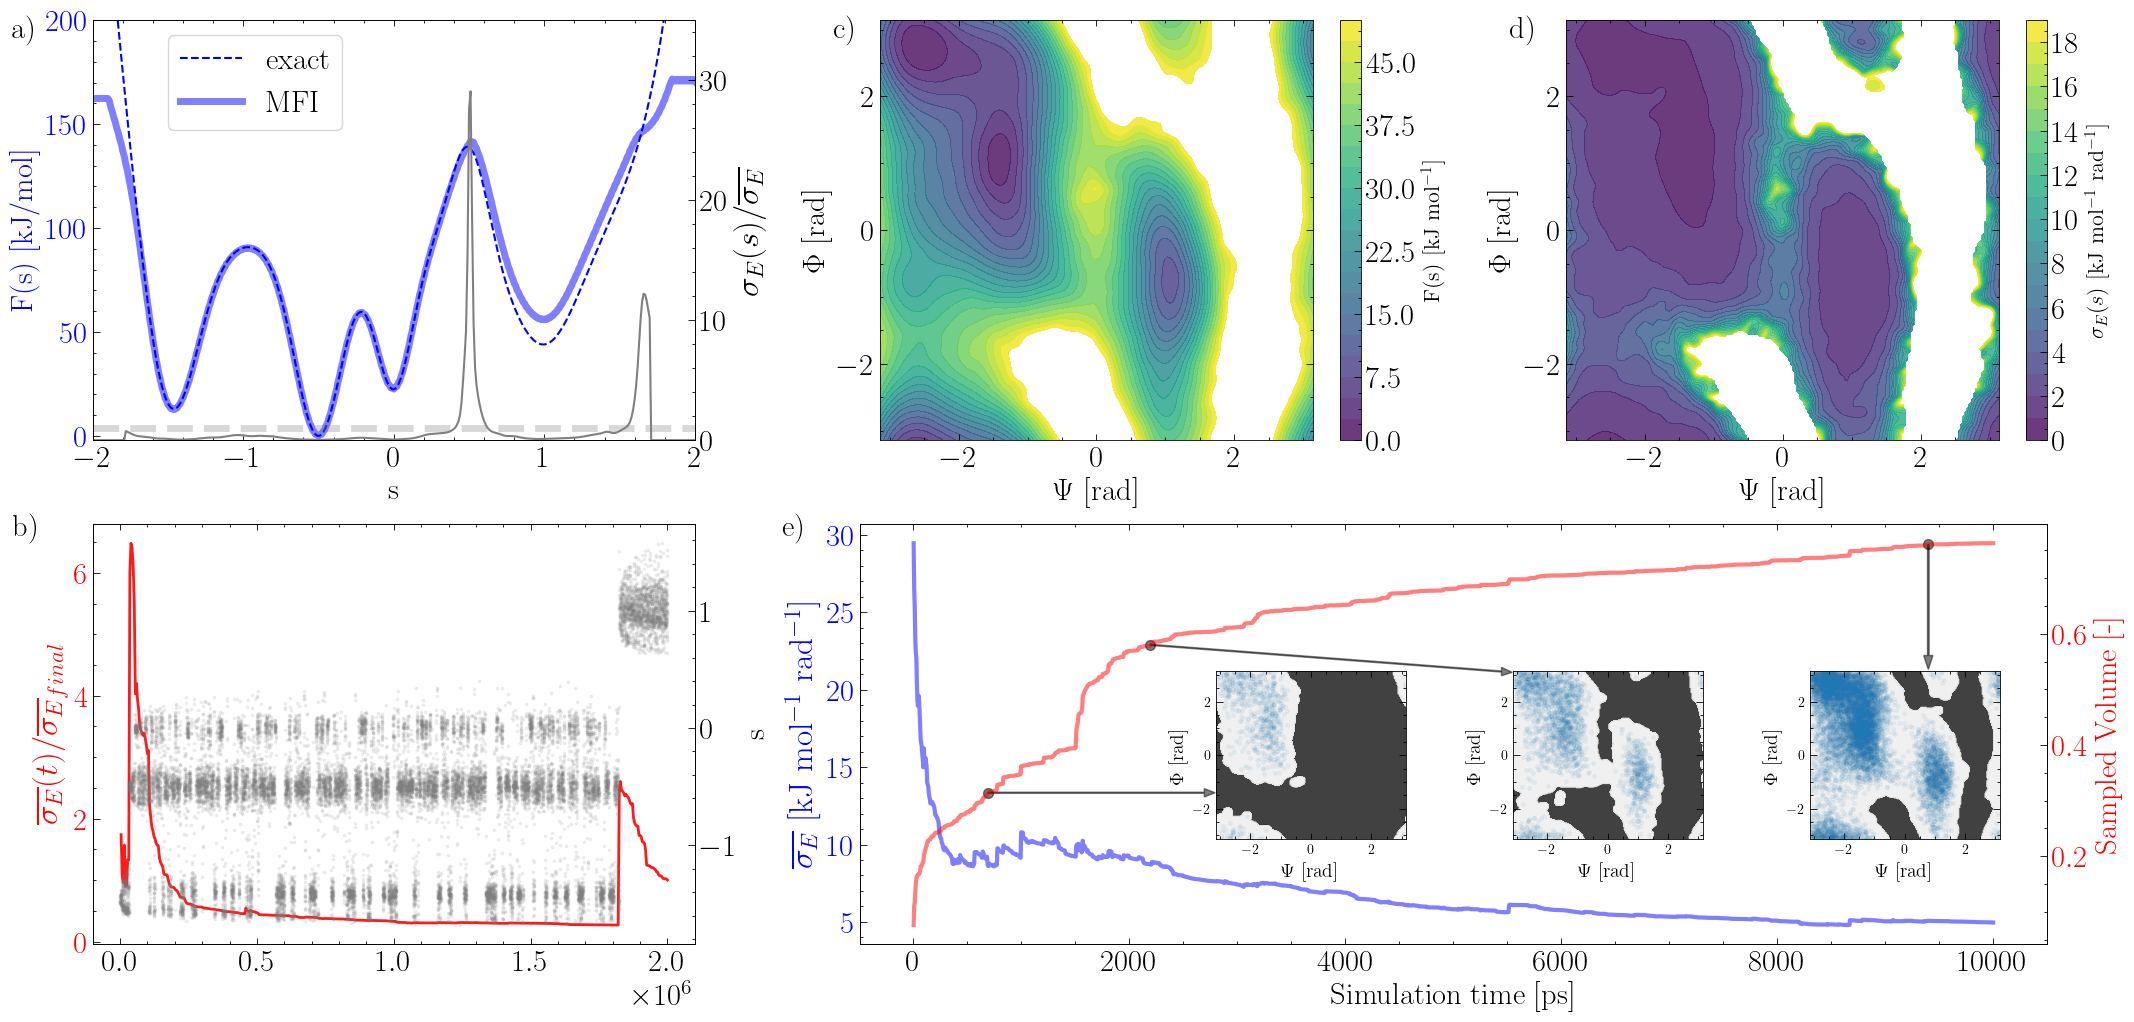

In [40]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(26,12))
gs = gridspec.GridSpec(2, 100)


ax1 = fig.add_subplot(gs[0, :30])
ax12 = ax1.twinx()
ax2 = fig.add_subplot(gs[0, 39:66])  
ax3 = fig.add_subplot(gs[0, 73:]) 
ax4 = fig.add_subplot(gs[1, :30])
ax42 = ax4.twinx() 
ax5 = fig.add_subplot(gs[1, 38:97])
ax52 = ax5.twinx() 



#################   Plot FES and ofe  #################

#Left plot
ax1.set_ylabel('F(s) [kJ/mol]',color='blue')
ax1.set_xlabel('s')
ax1.set_xlim(-2,2)
ax1.set_ylim(-2,200)
ax1.plot(x, y-min(y),'--',color='blue',label='exact');
ax1.plot(X_dw, FES_dw,color='blue',linewidth=5,alpha=0.5,label="MFI");
ax1.tick_params(axis ='y', labelcolor = 'blue')
ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1))

ax12.set_ylabel('$\sigma_E(s)/\overline{\sigma_E}$', fontsize=24, color='black')
ax12.tick_params(axis ='y', labelcolor = 'black', right = True , labelright = True ) 
ax12.set_ylim([0, 35] ) 
# ax1.set_yscale("log")
# ax1.plot(X_dw, ofe_dw*cutoff_dw/np.mean((ofe_dw)*cutoff_dw),color="grey",label="$\sigma^2(s)$");
ax12.plot(X_dw, ofe_dw*cutoff_dw / (np.sum(ofe_dw*cutoff_dw) / np.count_nonzero(cutoff_dw)),color="grey");
ax12.plot(X_dw, np.zeros(len(X_dw))+1,'--',linewidth=5,color="grey", alpha=0.3);

#################   ofe progression and CV progresstion  #################

ax4.plot([time/0.005 for time in error_evol_dw[3]], error_evol_dw[1]/error_evol_dw[1][np.size(error_evol_dw[1])-1],color='red',linewidth=2,alpha=0.9);
ax4.set_ylabel('$\overline{\sigma_E}(t)/\overline{\sigma_E}_{final}$', fontsize=24, color='red')
ax4.tick_params(axis ='y', labelcolor = 'red')
ax42.set_xlabel('Simulation steps')
ax42.set_ylabel('s',color='black')
ax42.tick_params(axis ='y', labelcolor = 'black')
ax42.scatter(HILLS_dw[:,0]/0.005,HILLS_dw[:,1],color='grey',s=3, alpha=0.1)

#################   FES ALANINE DIPEPTIDE FES  #################


cp = ax2.contourf(X, Y, FES_1, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=ax2)
cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16)
ax2.set_ylabel('$\Phi$ [rad]')
ax2.set_xlabel('$\Psi$ [rad]')
ax2.set_xlim(np.min(X),np.max(X))
ax2.set_ylim(np.min(Y),np.max(Y))

#################   OFE ALANINE DIPEPTIDE OFE  #################

cp = ax3.contourf(X, Y, MFI.zero_to_nan(ofe_1*cutoff_1), levels=np.arange(0, 20, 1), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=ax3)
cbar.set_label("$\sigma_E(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16)
ax3.set_ylabel('$\Phi$ [rad]')
ax3.set_xlabel('$\Psi$ [rad]')
ax3.set_xlim(np.min(X),np.max(X))
ax3.set_ylim(np.min(Y),np.max(Y))

#################  ALANINE DIPEPTIDE error progression  #################


ax5.plot( [time for time in time_history[1:]], (ofe_history[1:NH]),color='blue',alpha=0.5,linewidth=3);
ax5.set_ylabel('$\overline{\sigma_E}$ [kJ mol$^{-1}$ rad$^{-1}$]',fontsize=24, color='blue')
ax5.tick_params(axis ='y', labelcolor = 'blue')
ax5.set_xlabel('Simulation time [ps]')

# V=np.multiply(volume_history[1:NH],np.power(2*np.pi,2))
ax52.set_xlabel('Simulation steps')
ax52.set_ylabel('Sampled Volume [-]',color='red')
ax52.tick_params(axis ='y', labelcolor = 'red')
ax52.plot( [time for time in time_history[1:]], volume_history[1:NH],color='red',alpha=0.5,linewidth=3);

# plt.tight_layout()

#################  ALANINE DIPEPTIDE sampling  #################

inset_ax51 = inset_axes(ax5, width="16%", height="40%", loc = 'center' , bbox_to_anchor = ( -0.12, -0.05 , 1, 1), bbox_transform=ax5.transAxes, borderpad=3)
inset_ax51.contourf(X, Y, cutoff_700, cmap='gray', antialiased=False, alpha=0.8);
inset_ax51.scatter(HILLS[0:700,1],HILLS[0:700,2],s=7, alpha=0.05);
inset_ax51.set_ylabel('$\Phi$ [rad]', fontsize=14)
inset_ax51.set_xlabel('$\Psi$ [rad]', fontsize=14)
inset_ax51.set_xlim(np.min(X),np.max(X))
inset_ax51.set_ylim(np.min(Y),np.max(Y))
inset_ax51.tick_params(axis='both', labelsize=10)

inset_ax52 = inset_axes(ax5, width="16%", height="40%", loc = 'center' , bbox_to_anchor = ( 0.13, -0.05 , 1, 1), bbox_transform=ax5.transAxes, borderpad=3)
inset_ax52.contourf(X, Y, cutoff_2200, cmap='gray', antialiased=False, alpha=0.8);
inset_ax52.scatter(HILLS[0:2200,1],HILLS[0:2200,2],s=7, alpha=0.05);
inset_ax52.set_ylabel('$\Phi$ [rad]', fontsize=14)
inset_ax52.set_xlabel('$\Psi$ [rad]', fontsize=14)
inset_ax52.set_xlim(np.min(X),np.max(X))
inset_ax52.set_ylim(np.min(Y),np.max(Y))
inset_ax52.tick_params(axis='both', labelsize=10)

inset_ax53 = inset_axes(ax5, width="16%", height="40%", loc = 'center' , bbox_to_anchor = ( 0.38, -0.05 , 1, 1), bbox_transform=ax5.transAxes, borderpad=3)
inset_ax53.contourf(X, Y, cutoff_9400, cmap='gray', antialiased=False, alpha=0.8);
inset_ax53.scatter(HILLS[0:9400,1],HILLS[0:9400,2],s=7, alpha=0.05);
inset_ax53.set_ylabel('$\Phi$ [rad]', fontsize=14)
inset_ax53.set_xlabel('$\Psi$ [rad]', fontsize=14)
inset_ax53.set_xlim(np.min(X),np.max(X))
inset_ax53.set_ylim(np.min(Y),np.max(Y))
inset_ax53.tick_params(axis='both', labelsize=10)


#################  ALANINE DIPEPTIDE plot arrow  #################

# ax52.quiver(700, volume_history[int(700/5)] * (2*np.pi)**2, 2000, 0, scale_units='x', angles='xy', scale=1, linewidth=3)

arrow_style = {"head_width":0.015, "head_length":100, "color":"k", "width":0.002}
ax52.scatter(700, volume_history[int(700/5)], s=50, c="black", alpha=0.5)
ax52.arrow(x=700, y=volume_history[int(700/5)], dx=2000, dy=0, alpha=0.5, **arrow_style)

ax52.scatter(2200, volume_history[int(2200/5)], s=50, c="black", alpha=0.5)
ax52.arrow(x=2200, y=volume_history[int(2200/5)], dx=3250, dy=-0.048, alpha=0.5, **arrow_style)

arrow_style = {"head_width":85, "head_length":0.025, "color":"k", "width":15}
ax52.scatter(9400, volume_history[int(9400/5)], s=50, c="black", alpha=0.5)
ax52.arrow(x=9400, y=volume_history[int(9400/5)], dx=0, dy=-0.2, alpha=0.5, **arrow_style)

#################  PLOT TEXT  #################

h = [0.865, 0.45]
w = [0.094, 0.41, 0.67]
w22 = 0.39

fig.text(x=w[0], y=h[0], s="a)"); fig.text(x=w[1], y=h[0], s="c)"); fig.text(x=w[2], y=h[0], s="d)")
fig.text(x=w[0], y=h[1], s="b)"); fig.text(x=w22, y=h[1], s="e)")

plt.savefig(path_manustript + "Figure1A/" + 'Figure1.png', dpi=600, bbox_inches='tight')

plt.show()


In [163]:
print(np.multiply(volume_history[int(700/5)],np.power(2*np.pi,2)))

12.395236167328125
